# Traditional Object Recognition

Load and preprocess the MNIST dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from tensorflow.keras.datasets import mnist

# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Display 10 random samples from the training dataset


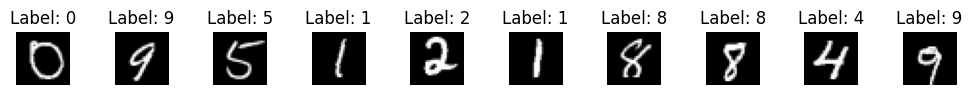

In [3]:
num_samples = 10
random_indices = np.random.choice(len(x_train), num_samples, replace=False)

plt.figure(figsize=(10, 1))
for i, idx in enumerate(random_indices):
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(x_train[idx], cmap='gray')
    plt.title(f"Label: {y_train[idx]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

Preprocess data: Flatten images and normalize

In [4]:
x = np.concatenate((x_train, x_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)

x = x.reshape(-1, 28 * 28).astype(np.float32) / 255.0  # Flatten and normalize
y = y.astype(np.int32)


Split into training and testing datasets

In [5]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

Train the KNN model


In [6]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(x_train, y_train)
accuracy = knn.score(x_test, y_test)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 97.01%


Test the model


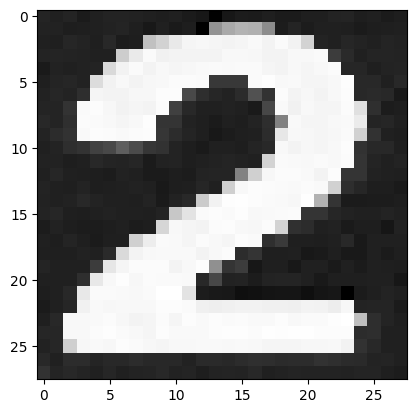

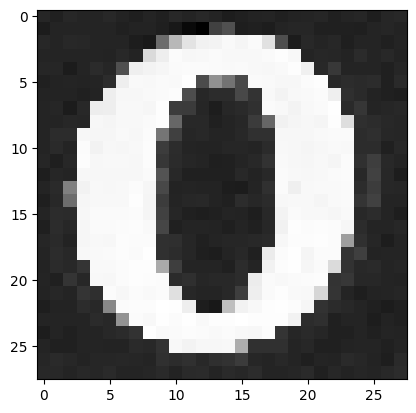

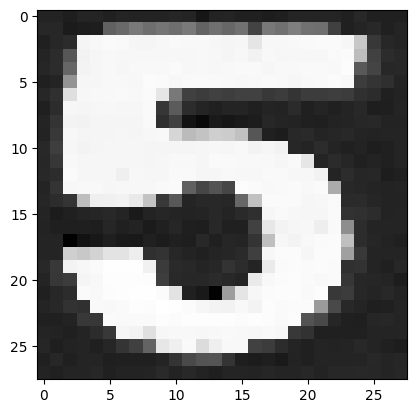

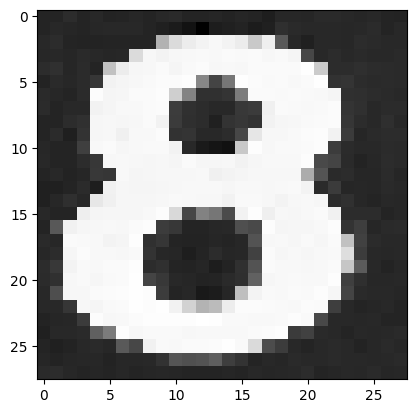

[2 0 0 0]


In [7]:
# Load the license plate image
image = cv2.imread("license_plate.jpg")

# Convert to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# # Invert the colors
inverted_image = cv2.bitwise_not(gray_image)

# Define the coordinates of the 4-digit region
x, y, w, h = 2290, 255, 2150, 880
digit_region = inverted_image[y:y+h, x:x+w]

# Resize the region to a fixed size for consistent splitting
digit_region_resized = cv2.resize(digit_region, (112, 28))

# Split the region into 4 equal parts
digits = np.hsplit(digit_region_resized, 4)
# Display each digit (for debugging)
for i, digit in enumerate(digits):
    plt.imshow(digit, cmap='gray')
    plt.show()
# Classify the digit
digits = np.array(digits).reshape(-1, 784).astype(np.float32)
print(knn.predict(digits))



# Deep Learning Object Recognition

In [8]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import cv2

Define the CNN architecture

In [9]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # First convolutional layer: Input 1 channel, output 32 channels, kernel size 3x3
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)  # Max pooling with 2x2 window
        # Second convolutional layer: Input 32 channels, output 64 channels, kernel size 3x3
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        # Third convolutional layer: Input 64 channels, output 128 channels, kernel size 3x3
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 3 * 3, 512)  # Input size after flattening
        self.fc2 = nn.Linear(512, 10)  # Output 10 classes for MNIST

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # Apply conv1 and pooling
        x = self.pool(torch.relu(self.conv2(x)))  # Apply conv2 and pooling
        x = self.pool(torch.relu(self.conv3(x)))  # Apply conv3 and pooling
        x = x.view(-1, 128 * 3 * 3)  # Flatten the output for fully connected layers
        x = torch.relu(self.fc1(x))  # Apply the first fully connected layer
        x = self.fc2(x)  # Apply the second fully connected layer (output)
        return x

Load MNIST Dataset


In [10]:
def load_mnist_data(batch_size=64):
    # Define data augmentation transforms for the training set
    train_transform = transforms.Compose([
        transforms.RandomRotation(degrees=15),  # Randomly rotate the image by ±15 degrees
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Randomly translate up to 10% of the image size
        transforms.RandomPerspective(distortion_scale=0.2, p=0.5),  # Apply random perspective transformations
        transforms.ToTensor(),  # Convert PIL image to Tensor
        transforms.Normalize((0.5,), (0.5,))  # Normalize to mean=0.5, std=0.5
    ])

    # Transform for the test set (no augmentation)
    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    # Load datasets
    trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=train_transform)
    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

    testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=test_transform)
    testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

    return trainloader, testloader


Train the Model


In [11]:
def train_model(model, trainloader, criterion, optimizer, device, num_epochs=5):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {running_loss/len(trainloader):.4f}")

Test the Model


In [12]:
def test_model(model, testloader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Accuracy: {100 * correct / total:.2f}%")


Predict Digits from a License Plate Image


In [13]:
def predict_license_plate(model, device):
    model.eval()
    transform = transforms.Compose([transforms.ToPILImage(), transforms.Grayscale(), transforms.Resize((28, 28)), transforms.ToTensor()])
    gray_image = cv2.imread("license_plate.jpg", cv2.IMREAD_GRAYSCALE)
    inverted_image = cv2.bitwise_not(gray_image)
    x, y, w, h = 2290, 255, 2150, 880
    digit_region = inverted_image[y:y+h, x:x+w]
    digit_region_resized = cv2.resize(digit_region, (112, 28))
    digits = np.hsplit(digit_region_resized, 4)
    for digit in digits:
        image = transform(digit).unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(image)
            _, predicted = torch.max(output, 1)
            print(f"Predicted Digit: {predicted.item()}")



In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Model, Loss, and Optimizer
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Load data
trainloader, testloader = load_mnist_data()

# Train and Test
train_model(model, trainloader, criterion, optimizer, device, num_epochs=10)
test_model(model, testloader, device)

# Predict digits from license plate images
predict_license_plate(model, device)

Using device: cuda
Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 11.5MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 345kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.14MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 9.09MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Epoch 1, Loss: 0.2429
Epoch 2, Loss: 0.0784
Epoch 3, Loss: 0.0619
Epoch 4, Loss: 0.0528
Epoch 5, Loss: 0.0497
Epoch 6, Loss: 0.0445
Epoch 7, Loss: 0.0423
Epoch 8, Loss: 0.0377
Epoch 9, Loss: 0.0368
Epoch 10, Loss: 0.0343
Accuracy: 99.32%
Predicted Digit: 2
Predicted Digit: 0
Predicted Digit: 5
Predicted Digit: 0
